### Deep Convolutional Generative Adversarial Networks

<div> <img src="dc1.png" alt="Drawing" style="width: 600px;"/></div> 


https://blogs.mathworks.com/deep-learning/files/2021/10/BP3_fig1-1024x390.jpg

In [12]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Reshape
from keras.layers import BatchNormalization
from tensorflow.python.keras.layers import UpSampling2D, Conv2D
from tensorflow.python.keras.layers import ELU
from tensorflow.python.keras.layers import Flatten, Dropout
from tensorflow.python.keras.optimizers import adam_v2
from keras.datasets import mnist

import numpy as np
import glob
import os
import math
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (_, _) = mnist.load_data()

In [3]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

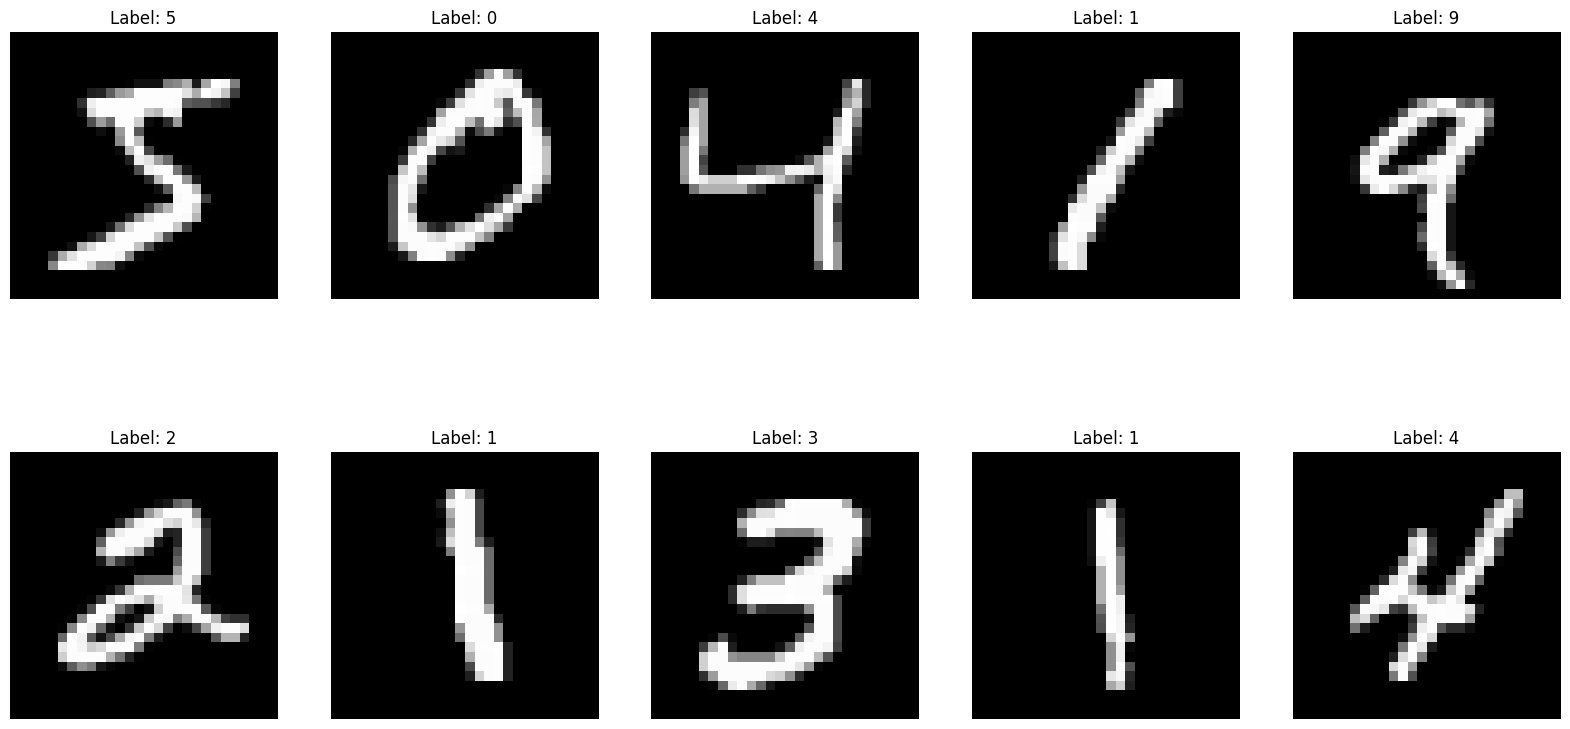

In [4]:
plt.figure(figsize=(20,10))

for i, img in enumerate(x_train[:10]):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns, and index i+1
    plt.imshow(img, cmap='gray')  # Assuming grayscale images
    plt.title(f"Label: {y_train[i]}")  # Add title with corresponding label
    plt.axis('off')  # Hide axis
    

In [6]:
def combine_images(generated_images):
    total,width,height = generated_images.shape[:-1]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[:, :, 0]
    return combined_image


def show_progress(epoch, batch, g_loss, d_loss, g_acc, d_acc):
    msg = "epoch: {}, batch: {}, g_loss: {}, d_loss: {}, g_accuracy: {}, d_accuracy: {}"
    print(msg.format(epoch, batch, g_loss, d_loss, g_acc, d_acc))


In [7]:
def generator(input_dim=100, units=1024, activation='relu'):
    model = Sequential()
    model.add(Dense(input_dim=input_dim, units=units)) ## 1024
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(128*7*7)) ## 128*7*7 = 6272
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,))) ##7, 7, 128
    model.add(UpSampling2D((2, 2)))  ## (14, 14, 128)
    model.add(Conv2D(64, (5, 5), padding='same')) ## (14, 14, 64)
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(UpSampling2D((2, 2)))  ## (28, 28, 64)
    model.add(Conv2D(1, (5, 5), padding='same')) ## (28, 28, 1)
    model.add(Activation('tanh'))
    print(model.summary())
    return model

In [8]:
def discriminator(input_shape=(28, 28, 1), nb_filter=64):
    model = Sequential()
    model.add(Conv2D(nb_filter, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape)) ## (14, 14, 64)
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Conv2D(2*nb_filter, (5, 5), strides=(2, 2))) ## (5, 5, 128)
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Flatten())  ## (7*7*2*nb_filter,)
    model.add(Dense(4*nb_filter)) ## 256
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1))  ##: (1,)
    model.add(Activation('sigmoid'))
    print(model.summary())
    return model
   

In [9]:
batch_size = 32
num_epoch = 5
learning_rate = 0.0001

In [52]:
image_path = 'images/'

if not os.path.exists(image_path):
    os.mkdir(image_path)


In [10]:
def train(x_train):
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) ##  (60000, 28, 28,1)

    gen = generator()
    dis = discriminator()

    optimize = adam_v2.Adam(learning_rate=learning_rate, beta_1=0.5)
    gen.trainable = True
    dis.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=optimize)

    dis.trainable = False
    dcgan = Sequential([gen, dis])
    dcgan.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=optimize)

    num_batches = x_train.shape[0] // batch_size
    gen_img = np.array([np.random.uniform(-1, 1, 100) for _ in range(49)]) #noise 49 images
    y_d_true = np.asarray([1] * batch_size)  # true
    y_d_gen = np.asarray([0] * batch_size)   # disc
    y_g = np.asarray([1] * batch_size)       # gen


    for epoch in range(num_epoch):
        for i in range(num_batches):
            x_d_batch = x_train[i*batch_size:(i+1)*batch_size]
            x_g = np.array([np.random.normal(0, 0.5, 100) for _ in range(batch_size)])
            x_d_gen = gen.predict(x_g)

            d_loss = dis.train_on_batch(x_d_batch, y_d_true)
            d_loss = dis.train_on_batch(x_d_gen, y_d_gen)

            g_loss = dcgan.train_on_batch(x_g, y_g)
            show_progress(epoch, i, g_loss[0], d_loss[0], g_loss[1], d_loss[1])

        image = combine_images(gen.predict(gen_img))
        image = image * 127.5 + 127.5
        Image.fromarray(image.astype(np.uint8)).save(image_path + "%03d.png" % (epoch))


In [11]:
train(x_train)

2024-03-25 02:34:48.743675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 02:34:48.749295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 02:34:48.749569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 02:34:48.750079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 6272)              25088     
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0

2024-03-25 02:34:50.142020: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


epoch: 0, batch: 0, g_loss: 0.5609676241874695, d_loss: 1.0360846519470215, g_accuracy: 0.8125, d_accuracy: 0.4375
epoch: 0, batch: 1, g_loss: 0.7998584508895874, d_loss: 1.1026828289031982, g_accuracy: 0.59375, d_accuracy: 0.375
epoch: 0, batch: 2, g_loss: 0.7801737189292908, d_loss: 1.0220131874084473, g_accuracy: 0.625, d_accuracy: 0.375
epoch: 0, batch: 3, g_loss: 0.6906291842460632, d_loss: 0.9821312427520752, g_accuracy: 0.625, d_accuracy: 0.5
epoch: 0, batch: 4, g_loss: 0.7006532549858093, d_loss: 1.0437235832214355, g_accuracy: 0.6875, d_accuracy: 0.40625
epoch: 0, batch: 5, g_loss: 0.7800295948982239, d_loss: 1.1509953737258911, g_accuracy: 0.59375, d_accuracy: 0.3125
epoch: 0, batch: 6, g_loss: 1.081209659576416, d_loss: 0.9524520635604858, g_accuracy: 0.5, d_accuracy: 0.46875
epoch: 0, batch: 7, g_loss: 0.6820337772369385, d_loss: 0.968921422958374, g_accuracy: 0.6875, d_accuracy: 0.5
epoch: 0, batch: 8, g_loss: 0.7023482918739319, d_loss: 1.1244661808013916, g_accuracy: 0.5

2024-03-25 02:35:39.410120: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


epoch: 0, batch: 668, g_loss: 0.7763992547988892, d_loss: 0.8385930061340332, g_accuracy: 0.53125, d_accuracy: 0.34375
epoch: 0, batch: 669, g_loss: 0.811773419380188, d_loss: 0.7893915176391602, g_accuracy: 0.5, d_accuracy: 0.53125
epoch: 0, batch: 670, g_loss: 0.8644762635231018, d_loss: 0.6916950941085815, g_accuracy: 0.53125, d_accuracy: 0.5625
epoch: 0, batch: 671, g_loss: 0.7407938241958618, d_loss: 0.8694604635238647, g_accuracy: 0.65625, d_accuracy: 0.40625
epoch: 0, batch: 672, g_loss: 0.7075207829475403, d_loss: 0.8110163807868958, g_accuracy: 0.53125, d_accuracy: 0.46875
epoch: 0, batch: 673, g_loss: 0.9297231435775757, d_loss: 0.8689090013504028, g_accuracy: 0.40625, d_accuracy: 0.375


KeyboardInterrupt: 

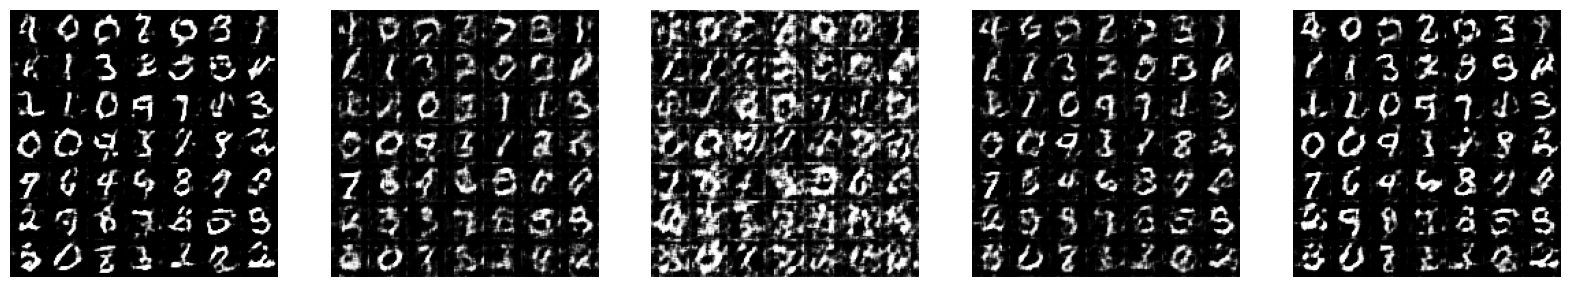

In [16]:
plt.figure(figsize=(20,10))

gen_images = glob.glob('images/*.png')

for i, img_path in enumerate(gen_images):
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)  
    plt.imshow(img, cmap='gray')  # Assuming grayscale images
    plt.axis('off')  
    